# March 6 - Clustering

In this notebook, we'll follow along some scikit learn examples for clustering.

First, we'll demonstrate KMeans.

In [24]:
import numpy as np

from sklearn.datasets import make_blobs

n_samples = 1500
random_state = 170
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]

X, y = make_blobs(n_samples=n_samples, random_state=random_state)
X_aniso = np.dot(X, transformation)  # Anisotropic blobs
X_varied, y_varied = make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)  # Unequal variance
X_filtered = np.vstack(
    (X[y == 0][:500], X[y == 1][:100], X[y == 2][:10])
)  # Unevenly sized blobs
y_filtered = [0] * 500 + [1] * 100 + [2] * 10

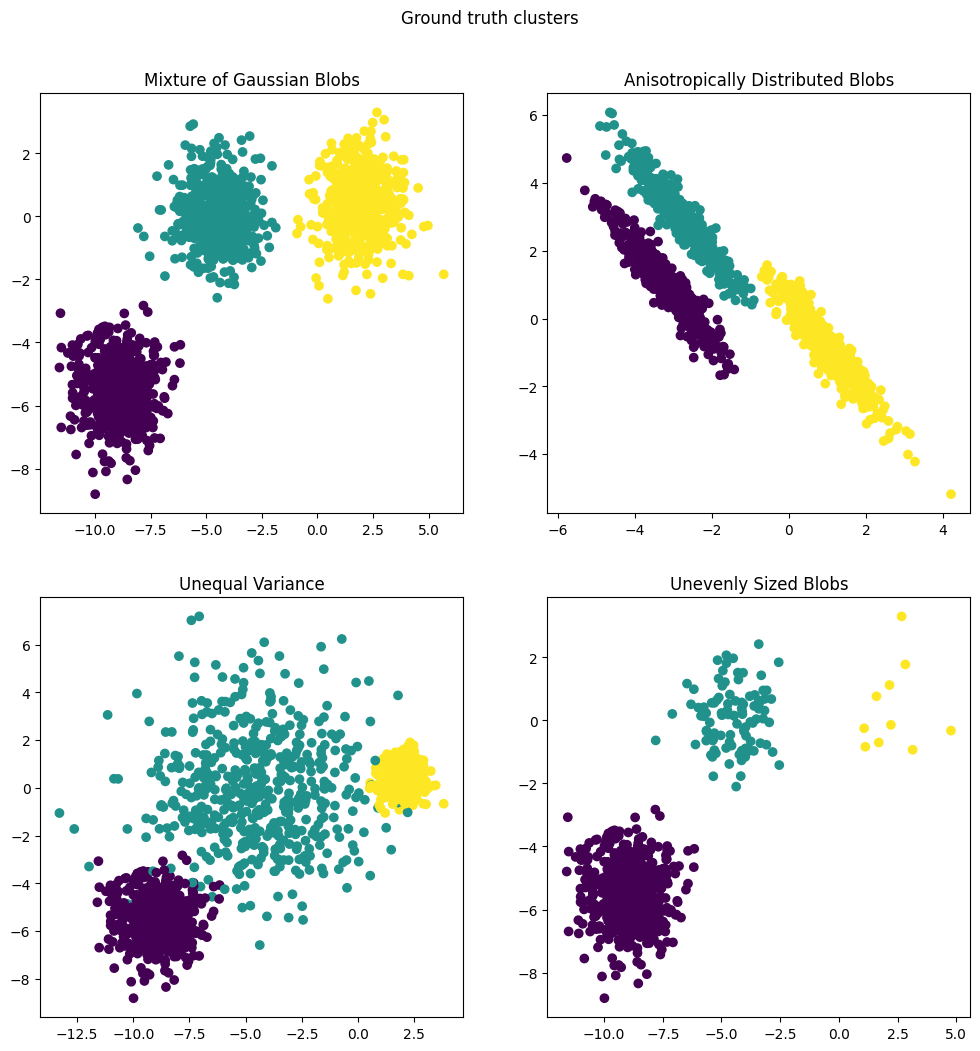

In [25]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

axs[0, 0].scatter(X[:, 0], X[:, 1], c=y)
axs[0, 0].set_title("Mixture of Gaussian Blobs")

axs[0, 1].scatter(X_aniso[:, 0], X_aniso[:, 1], c=y)
axs[0, 1].set_title("Anisotropically Distributed Blobs")

axs[1, 0].scatter(X_varied[:, 0], X_varied[:, 1], c=y_varied)
axs[1, 0].set_title("Unequal Variance")

axs[1, 1].scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_filtered)
axs[1, 1].set_title("Unevenly Sized Blobs")

plt.suptitle("Ground truth clusters").set_y(0.95)
plt.show()

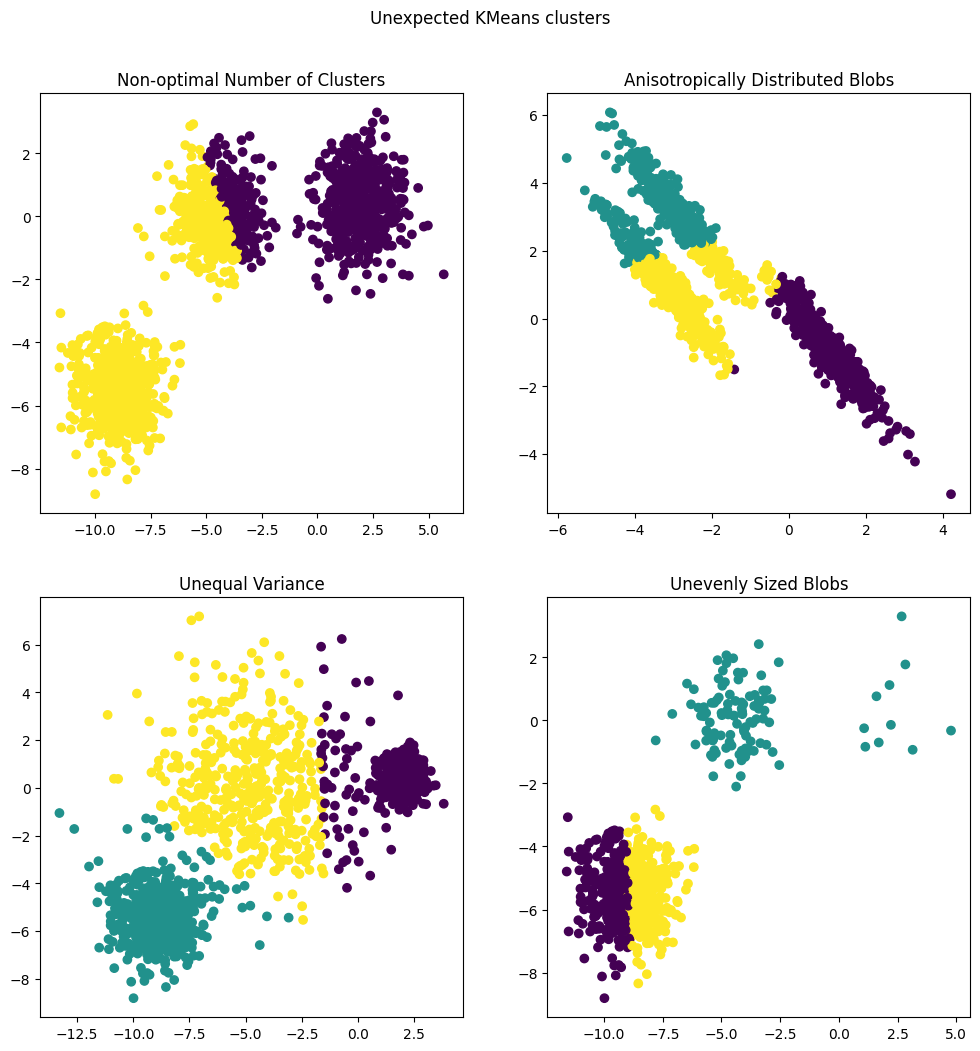

In [30]:
from sklearn.cluster import KMeans
import psutil

common_params = {
    "random_state": random_state,
}

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

y_pred = KMeans(n_clusters=2, **common_params).fit_predict(X)
axs[0, 0].scatter(X[:, 0], X[:, 1], c=y_pred)
axs[0, 0].set_title("Non-optimal Number of Clusters")

y_pred = KMeans(n_clusters=3, **common_params).fit_predict(X_aniso)
axs[0, 1].scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
axs[0, 1].set_title("Anisotropically Distributed Blobs")

y_pred = KMeans(n_clusters=3, **common_params).fit_predict(X_varied)
axs[1, 0].scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
axs[1, 0].set_title("Unequal Variance")

y_pred = KMeans(n_clusters=3, **common_params).fit_predict(X_filtered)
axs[1, 1].scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
axs[1, 1].set_title("Unevenly Sized Blobs")

plt.suptitle("Unexpected KMeans clusters").set_y(0.95)
plt.show()

Note that kMeans has some problems with this data.  It fits circular regions which won't be found typically in organic data, especially if it is skewed or scaled incorrectly.

We can also play with the hyperparameters - by increasing the number of clusters and by allowing more random initializations, we can learn some of these.

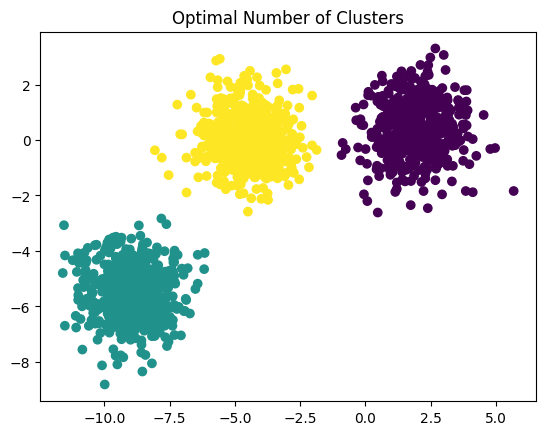

In [4]:
y_pred = KMeans(n_clusters=3, **common_params).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Optimal Number of Clusters")
plt.show()

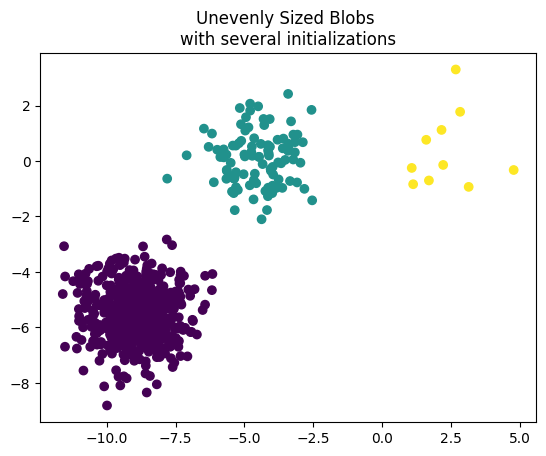

In [5]:
y_pred = KMeans(n_clusters=3, n_init=10, random_state=random_state).fit_predict(
    X_filtered
)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("Unevenly Sized Blobs \nwith several initializations")
plt.show()

Let's try our other clustering algorithms.  First, let's try DBscan with this same data.


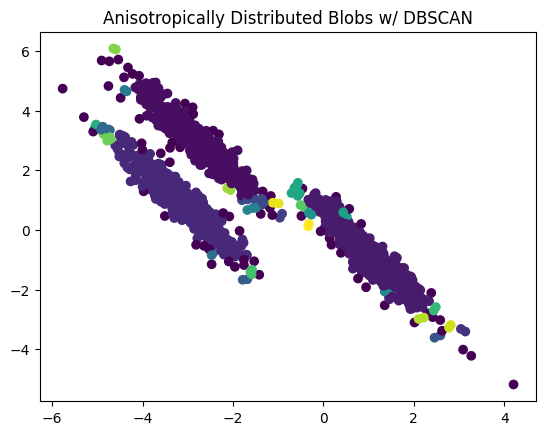

In [38]:
from sklearn.cluster import DBSCAN

y_pred = DBSCAN(eps=0.15, min_samples=2).fit_predict(X_aniso)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
plt.title("Anisotropically Distributed Blobs w/ DBSCAN")
plt.show()

Finally, let's look at the first dataset with hierarchical clustering.

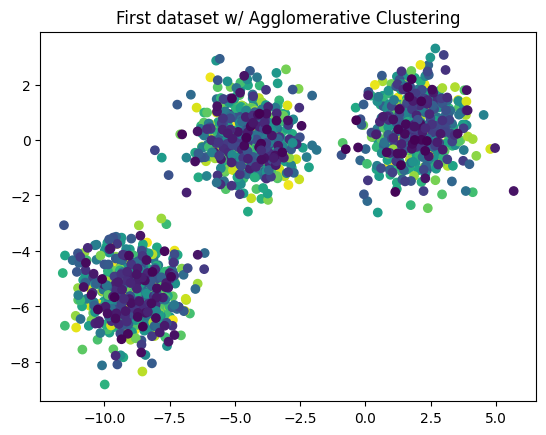

In [15]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(X)
y_pred = model.labels_.astype(int)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("First dataset w/ Agglomerative Clustering")
plt.show()

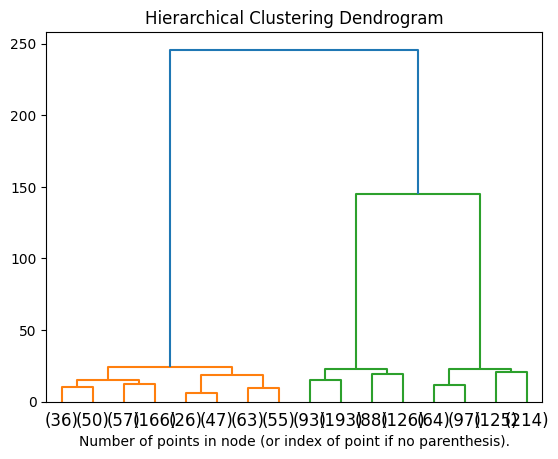

In [16]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [17]:
# Let's look at the labels a little closer.

model.labels_

array([ 929, 1217, 1119, ...,    4,    1,    0], shape=(1500,))

In [18]:
model.children_

array([[ 109, 1169],
       [ 716,  860],
       [ 515,  601],
       ...,
       [2990, 2991],
       [2994, 2995],
       [2996, 2997]], shape=(1499, 2))

This is pretty hard to interpret, so we can look at the [sklearn documentation:](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)

> `children_` array-like of shape (n_samples-1, 2)

    The children of each non-leaf node. Values less than n_samples correspond to leaves of the tree which are the original samples. A node i greater than or equal to n_samples is a non-leaf node and has children children_[i - n_samples]. Alternatively at the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i.


In [20]:
# That last sentence clarifies things.  So that first row,
model.children_[0]

array([ 109, 1169])

In [21]:
# This indicates to us that sample 109 and sample 1169 are clustered together.  They form sample node 1500.  So you would need to process this data to answer questions about the levels of hierarchies.